# 1. Business Understanding

The overal aim is to be able to predict the exit status of a startup. That is , Whether a startup is merged or acquired, goes public(IPO) or remains private. Th dataset used is sourced from crunchbase

## 1.1 Imports

In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score
import optuna
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix , plot_confusion_matrix,precision_score
import pickle
import json

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

## 1.2 Data

In [2]:
data = pd.read_csv("final.csv")

# 2. Exploratory Data Analysis

In [3]:
data.head()

,Organization Name,Funding Type,Money Raised,Announced Date,Organization Industries,Equity Only Funding,Funding Stage,Region,Country,City,Total Funding,Company Type,Number of Founders,Number of Employees,Funding Status
0,Retrocausal,Pre-Seed,120000.0,2000-02-01,"Artificial Intelligence (AI), Industrial Autom...",Yes,Seed,North America,United States,Seattle,120000.0,For Profit,3.0,1-10,Privado
1,Relationship Science,Series A,1000000.0,2000-04-20,"B2B, B2C, Business Development, Charity, Finan...",Yes,Early Stage Venture,North America,United States,New York,1000000.0,For Profit,1.0,501-1000,M&A
2,Aera Technology,Seed,1400000.0,2001-01-01,"Artificial Intelligence (AI), Business Intelli...",Yes,Seed,North America,United States,Mountain View,1400000.0,For Profit,2.0,251-500,Privado
3,LeewiART,Angel,3000000.0,2001-10-11,"Animation, Communities, Graphic Design",Yes,Seed,Asia,China,Beijing,3000000.0,For Profit,1.0,11-50,Privado
4,Spoke,Series A,4200000.0,2002-01-01,"Contact Management, CRM, Crowdsourcing, Email,...",Yes,Early Stage Venture,North America,United States,San Mateo,4200000.0,For Profit,4.0,11-50,Privado


In [4]:
#previewing the dimensions or shape (rows and columns)of the data

data.shape

(41318, 15)

In [5]:
#previewing the information about the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41318 entries, 0 to 41317
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Organization Name        41318 non-null  object 
 1   Funding Type             41318 non-null  object 
 2   Money Raised             41318 non-null  float64
 3   Announced Date           41318 non-null  object 
 4   Organization Industries  41318 non-null  object 
 5   Equity Only Funding      41318 non-null  object 
 6   Funding Stage            41318 non-null  object 
 7   Region                   41318 non-null  object 
 8   Country                  41318 non-null  object 
 9   City                     41318 non-null  object 
 10  Total Funding            41318 non-null  float64
 11  Company Type             41318 non-null  object 
 12  Number of Founders       41318 non-null  float64
 13  Number of Employees      41318 non-null  object 
 14  Funding Status        

In [6]:
#previewing the summary numerical statistics of our data

data.describe()

,Money Raised,Total Funding,Number of Founders
count,4.131800e+04,4.131800e+04,41318.000000
mean,1.460178e+08,2.904526e+08,2.279902
std,3.251395e+09,7.182801e+09,1.134428
min,0.000000e+00,0.000000e+00,1.000000
25%,4.000000e+05,6.150000e+05,1.000000
50%,2.400000e+06,3.300000e+06,2.000000
75%,1.080000e+07,1.910000e+07,3.000000
max,4.000000e+11,6.484640e+11,13.000000


In [7]:
#checking for missing values in our data

data.isnull().sum()

Organization Name          0
Funding Type               0
Money Raised               0
Announced Date             0
Organization Industries    0
Equity Only Funding        0
Funding Stage              0
Region                     0
Country                    0
City                       0
Total Funding              0
Company Type               0
Number of Founders         0
Number of Employees        0
Funding Status             0
dtype: int64

In [8]:
#checking for duplicated values in our data

data.duplicated().sum()

1

In [9]:
# drop duplicates
data = data.drop_duplicates()

In [10]:
#checking unique values

data.nunique()

Organization Name          18376
Funding Type                  13
Money Raised                3932
Announced Date              5205
Organization Industries    16207
Equity Only Funding            1
Funding Stage                  4
Region                         6
Country                       39
City                         167
Total Funding               8697
Company Type                   2
Number of Founders            13
Number of Employees            9
Funding Status                 3
dtype: int64

# 3. Preprocessing

In [11]:
train = data

In [12]:
# drop cols not used when modelling
train = train.drop(["Organization Name","Equity Only Funding", "Announced Date"], axis = 1 )

## Label Encoding

In [13]:
le=LabelEncoder()

In [14]:
cols = train.select_dtypes(include=['object']).columns.tolist()

In [15]:
cat_labels = {}

for col in cols:
    train[col] = le.fit_transform(train[col]) 
    cat_labels[col] = list(le.classes_)

In [109]:
# Convert and write JSON object to file
with open("feature_values.json", "w") as feature_values: 
    json.dump(cat_labels, feature_values)

## Drop Outliers

In [16]:
columns_to_drop_outliers = ["Money Raised", 'Total Funding']

In [17]:
train = train[(np.abs(stats.zscore(train[columns_to_drop_outliers])) < 3).all(axis=1)]
train = train.reset_index().drop("index", axis=1)

## Split

In [18]:
X = train.drop("Funding Status", axis=1)
y = train["Funding Status"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

# 4. Modelling

## Random Forest

In [20]:
rf = RandomForestClassifier(n_estimators=300)

In [21]:
rf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=300)

In [22]:
y_preds = rf.predict(X_test)

In [23]:
accuracy_score(y_preds,y_test) 

0.7798810823929134

In [24]:
print(confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test,y_preds))

[[ 113   31  285]
 [  34  235 1100]
 [  57  307 6079]]


              precision    recall  f1-score   support

           0       0.55      0.26      0.36       429
           1       0.41      0.17      0.24      1369
           2       0.81      0.94      0.87      6443

    accuracy                           0.78      8241
   macro avg       0.59      0.46      0.49      8241
weighted avg       0.73      0.78      0.74      8241



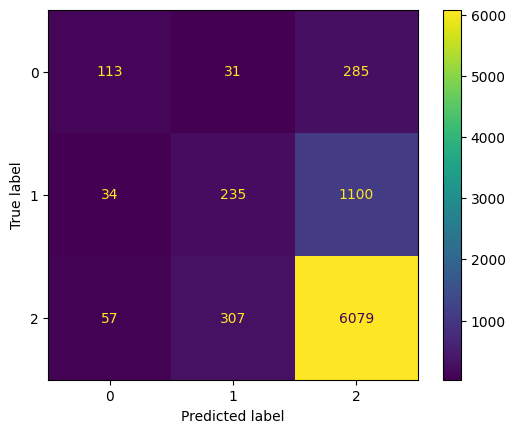

In [25]:
plot_confusion_matrix(rf, X_test,y_test)

## LGBM

In [26]:
# predictions = []
scores = []
i = 0
          
params = {'objective' : 'multiclass',
          'num_class': 3,
          'learning_rate': 0.09760323859805359, 
          'subsample': 0.1970825329000635, 
          'colsample_bytree': 0.9701158409610404, 
          'max_depth': 19, 
          'scale_pos_weight': 4, 
          'n_estimators': 961,
          'verbosity': -1}

fold = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)

for train_index,test_index in fold.split(X,y):
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]
    classifier = LGBMClassifier(**params)
    classifier.fit(X_train,y_train)
    preds = classifier.predict(X_test)
    score = accuracy_score(y_test,preds)
    scores.append(score)
    print("accuracy_score: " ,score)
    i = i+1
    
print(np.mean(scores))


accuracy_score:  0.8332928900752244
accuracy_score:  0.8325649114292647
accuracy_score:  0.8281970395535064
accuracy_score:  0.8291676777481194
accuracy_score:  0.8325649114292647
accuracy_score:  0.8325242718446602
accuracy_score:  0.8315533980582525
accuracy_score:  0.833252427184466
accuracy_score:  0.8320388349514564
accuracy_score:  0.8254854368932039
0.8310641799167418


In [27]:
y_preds = classifier.predict(X_test)

In [28]:
accuracy_score(y_preds,y_test) 

0.8254854368932039

**An accuracy of 83%**

In [29]:
print(confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test,y_preds))

[[ 133   13   69]
 [  15  186  480]
 [  17  125 3082]]


              precision    recall  f1-score   support

           0       0.81      0.62      0.70       215
           1       0.57      0.27      0.37       681
           2       0.85      0.96      0.90      3224

    accuracy                           0.83      4120
   macro avg       0.74      0.62      0.66      4120
weighted avg       0.80      0.83      0.80      4120



## Save Model

In [31]:
with open("exit_status_model_v1.pkl", "wb") as f:
    pickle.dump(classifier, f)

# 5. Inference

In [78]:
labels_names = cat_labels["Funding Status"]

In [100]:
sample = X_test.sample()

print('Actual: ',     labels_names[int(y_test.loc[sample.index[0]])])
print('Prediction: ', labels_names[np.argmax(classifier.predict(sample))])

Actual:  M&A
Prediction:  IPO
